I need to check that the amplitude of the maps of Radio Galaxies produced by WebSky are reasonable if compared to experimental results. The main worry is that being point sources, when we apply a beam using Spherical Harmonics transform we get spurious results due to the input maps not being band-limited.

In [1]:
pip install pysm3 --pre

Note: you may need to restart the kernel to use updated packages.


In [2]:
import healpy as hp
import pysm3
from pysm3 import units as u
%matplotlib inline

## Get the Planck beam widths

In [3]:
!wget -nc https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/LFI_RIMO_R3.31.fits

File ‘LFI_RIMO_R3.31.fits’ already there; not retrieving.



In [4]:
!wget -nc https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/HFI_RIMO_R3.00.fits

File ‘HFI_RIMO_R3.00.fits’ already there; not retrieving.



In [5]:
from astropy.io import fits

In [6]:
fwhm = {}

with fits.open("LFI_RIMO_R3.31.fits") as f:
  for ch, ch_fwhm in zip(f[2].data["FREQUENCY"], f[2].data["FWHM"]):
    fwhm[ch[0]] = ch_fwhm * u.arcmin

In [7]:
with fits.open("HFI_RIMO_R3.00.fits") as f:
  for ch, ch_fwhm in zip(f[1].data["FREQUENCY"], f[1].data["FWHM"]):
    fwhm[ch[0]] = ch_fwhm * u.arcmin

## Select a channel

"030" or "143"

In [8]:
ch = "030"
freq = float(ch) * u.GHz

In [9]:
instrument = "LFI" if freq < 100 * u.GHz else "HFI"
nside = 1024 if instrument == "LFI" else 2048
rel = "R3" if instrument == "LFI" else "R4"

## Load Planck maps

In [10]:
!wget -nc https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/LFI_SkyMap_030_1024_R3.00_full.fits

File ‘LFI_SkyMap_030_1024_R3.00_full.fits’ already there; not retrieving.



In [11]:
!wget -nc https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/HFI_SkyMap_143_2048_R4.00_full.fits

File ‘HFI_SkyMap_143_2048_R4.00_full.fits’ already there; not retrieving.



In [12]:
m_planck = hp.read_map(f"{instrument}_SkyMap_{ch}_{nside}_{rel}.00_full.fits")

In [13]:
m_planck = (m_planck * u.K_CMB).to(u.uK_CMB)

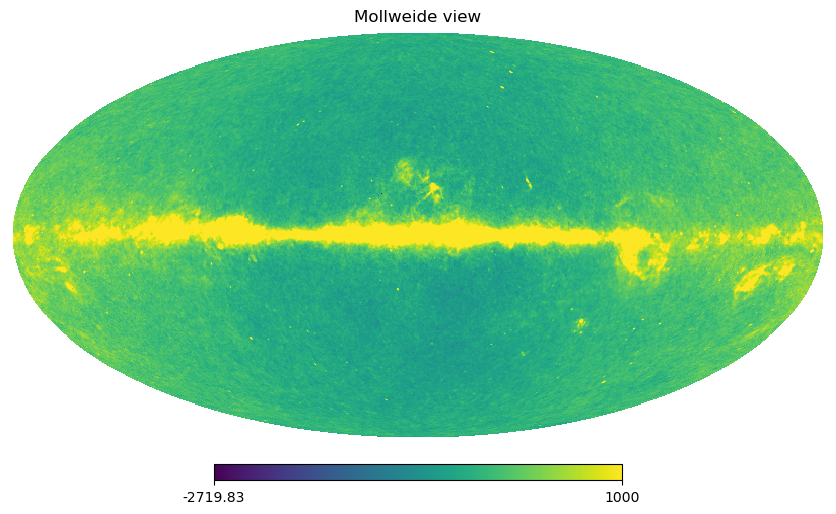

In [18]:
hp.mollview(hp.remove_dipole(m_planck), max=1e3)

## Create maps with PySM

In [14]:
sky = pysm3.Sky(nside=nside, preset_strings=["rg1"])

In [15]:
m_pysm = sky.get_emission(freq)

In [16]:
m_pysm_smoothed = pysm3.apply_smoothing_and_coord_transform(m_pysm, fwhm=fwhm[ch])

hp.map2alm_lsq did not converge in 10 iterations, residual relative error is 0.69


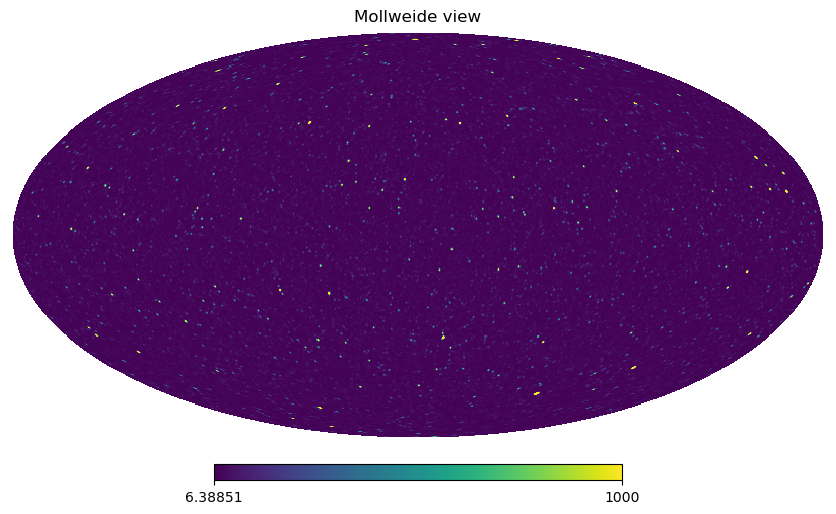

In [17]:
hp.mollview(m_pysm_smoothed[0], max=1e3)

## Visualize a point source

Check for ringing around point sources

In [19]:
max_pix = m_pysm_smoothed[0].argmax()

In [20]:
lon,lat= hp.pix2ang(nside, max_pix, lonlat=True)

In [21]:
lon

275.2809917355372

In [22]:
lat

-62.0850844513906

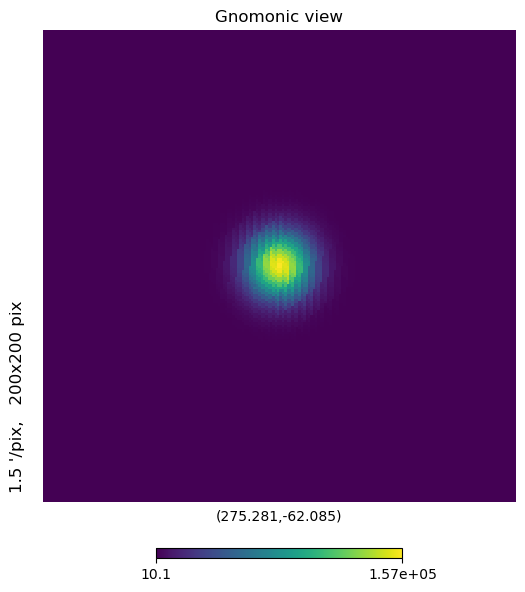

In [23]:
hp.gnomview(m_pysm_smoothed[0], rot=(lon,lat))

In [24]:
m_pysm_smoothed[0].max()

<Quantity 156551.45230006 uK_RJ>

In [25]:
m_planck.max()

<Quantity 215075.31 uK_CMB>